In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import plotly.offline as py_of
from plotly.subplots import make_subplots
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from itertools import product
from plotly import tools
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
from scipy.stats import entropy
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import make_scorer
import folium

# py_of.init_notebook_mode()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""
    # create the counts of samples under each node
    plt.figure(figsize=(30, 10))
    plt.title('Hierarchical Clustering Dendrogram')

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.xticks(fontsize=20, rotation=70)
    plt.show()

This dataset contains information about earthquakes: coordinates, depth and strength. My task is to cluster the data:  
● Exploratory analysis (there are some specific characteristics of features, which may change the result of the analysis)  
● K-Means with 15 clusters  
● Determined optimal number of clusters for K-Means   
● Created visualization for the obtained clusters  
● Tried other clustering algorithms; tuned their hyperparameters to achieve better results.  
● Used labelled and unlabeled metrics to estimate quality of clusters I built. As ground truth used cluster labels from K-Means, choosen most similar algorithm   
● Explained the final choice of best clusterizations: gave interpretation of clusters  
● Visualized the best clusterizations in my opinion on the world map.  

In [ ]:
url='https://drive.google.com/file/d/1S5stL1xz51y5QkGRHHfWqteacHDYOYXM/view?usp=sharing'
url2='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url2)
data.head()

Focal depth  Latitude  Longitude  Richter
0           33    -52.26      28.30      6.7
1           36     45.53     150.93      5.8
2           57     41.85     142.78      5.8
3           67     29.19     141.15      6.2
4           30    -21.66     169.81      6.0

### Univariate analysis

In [ ]:
data.describe()

Focal depth     Latitude    Longitude      Richter
count  2178.000000  2178.000000  2178.000000  2178.000000
mean     74.359963     7.961997    54.914835     5.977181
std     116.467797    30.545583   118.875581     0.189426
min       0.000000   -66.490000  -179.960000     5.800000
25%      21.000000   -12.432500   -67.782500     5.800000
50%      39.000000     0.210000   122.100000     5.900000
75%      68.000000    36.480000   146.860000     6.100000
max     656.000000    78.150000   180.000000     6.900000

In [ ]:
def pdf_cdf_visualize(data,**pdf_cdf_args):
    fig = plt.figure(figsize=(15,10))
    fig.suptitle(pdf_cdf_args['type_'],fontsize=20)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in (np.arange(data.shape[1]) + 1):
        ax = fig.add_subplot(2, 2, i)
        sns.distplot(data[str(data.columns[i-1])],hist=pdf_cdf_args['hist'],kde_kws=pdf_cdf_args['kde_kws'],color=pdf_cdf_args['color'])
        ax.title.set_text(data.columns[i-1])
    plt.show()

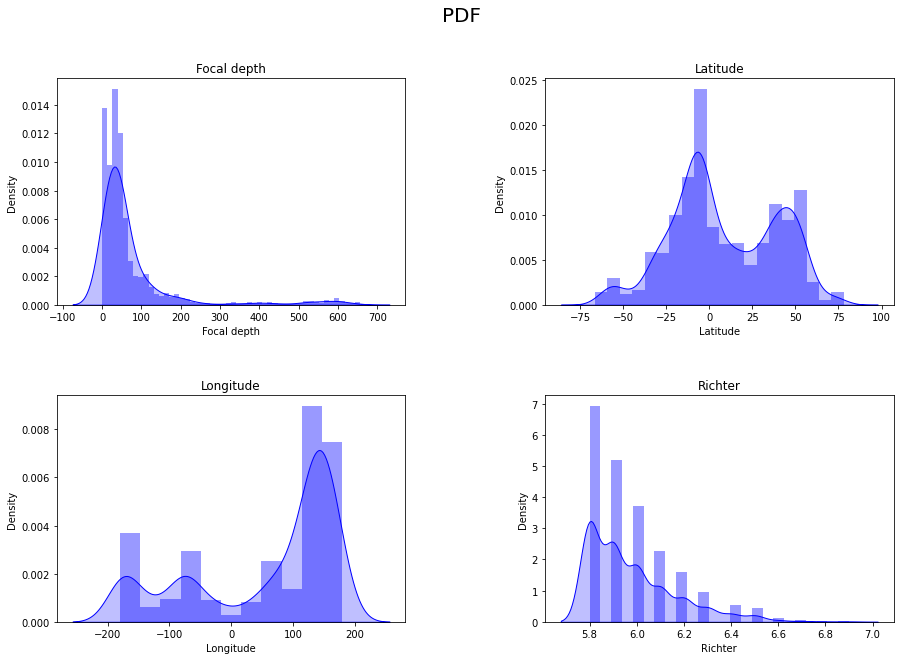

In [ ]:
pdf_cdf_visualize(data,type_='PDF',hist=True,kde_kws={"shade": True,"cumulative":False},color='blue');

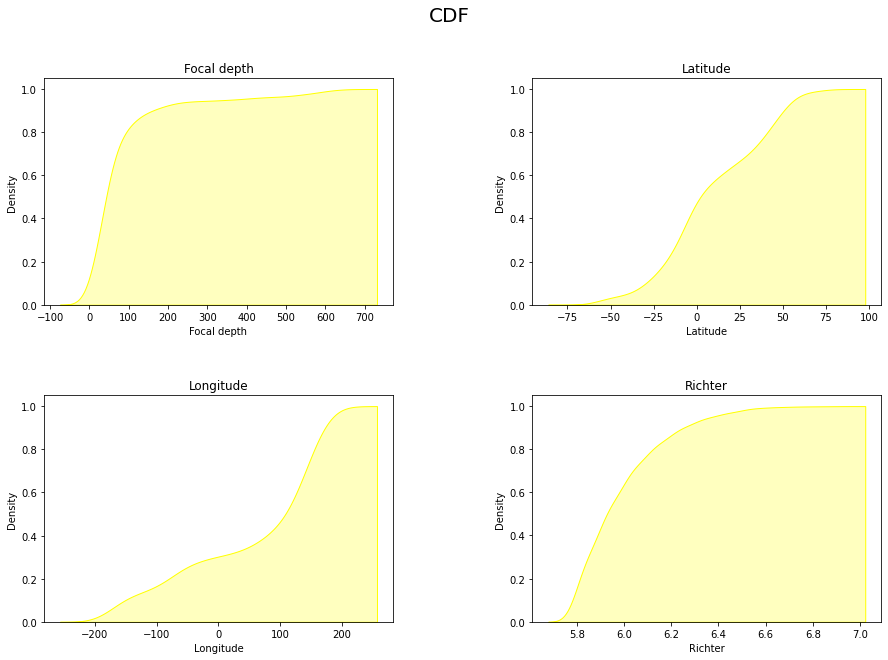

In [ ]:
pdf_cdf_visualize(data,type_='CDF',hist=False,kde_kws={"shade": True,"cumulative":True},color='yellow');

In [ ]:
for j in data.columns:
    print(f'Shapiro-Wilks test for normality column `{j}`: {stats.shapiro(data[j])}')

Shapiro-Wilks test for normality column `Focal depth`: (0.549601674079895, 0.0)
Shapiro-Wilks test for normality column `Latitude`: (0.9657411575317383, 2.4465070733541523e-22)
Shapiro-Wilks test for normality column `Longitude`: (0.8113372325897217, 7.006492321624085e-45)
Shapiro-Wilks test for normality column `Richter`: (0.8412981629371643, 3.346300732807663e-42)


Okay, test showed that there are no normally distributed features, the only one that resembles it is latitude.<br>
Richter and Focal depth are positively skewed and longitude is rather negatively skewed.<br>
Gradients on CDFs are highest on intervals:<br>
    &emsp;- Latitude [-50;0],[25,70] <br>
    &emsp;- Longitude [-200;-120],[-100;-20],[0;180] <br>
    &emsp;- Focal depth [0;200] <br>
    &emsp;- Richters scale [5.8;6.2] <br>

***Problem area here is that latitude and longitude have wraparound property.I mean, -179,179 longitude degrees - they're actually adjacent longitudes.That's a problem for algorithms with euclidean distance metric.Thus, I think it would be nice if we converted spherical system of coordinates(ro,theta(latitude),phi(longitude)) to Decarts R3(x,y,z).***<br>
`x = R_earth*cos(theta)*cos(phi)`<br>
`y = R_earth*cos(theta)*sin(phi)`<br>
`z = R_earth*sin(theta)`<br>
***Actually, R_earth here can be ignored(=1), because coordinates anyhow will be further normalized***

### Multivariative analysis

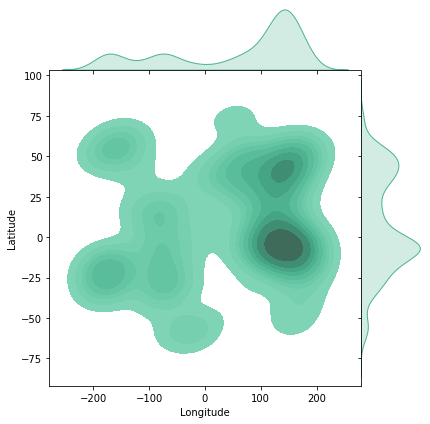

In [ ]:
sns.jointplot('Longitude','Latitude',data,kind="kde",space=0,fill=True, color="#4CB391");

There are 7 the most dense and geographically different areas of earthquakes

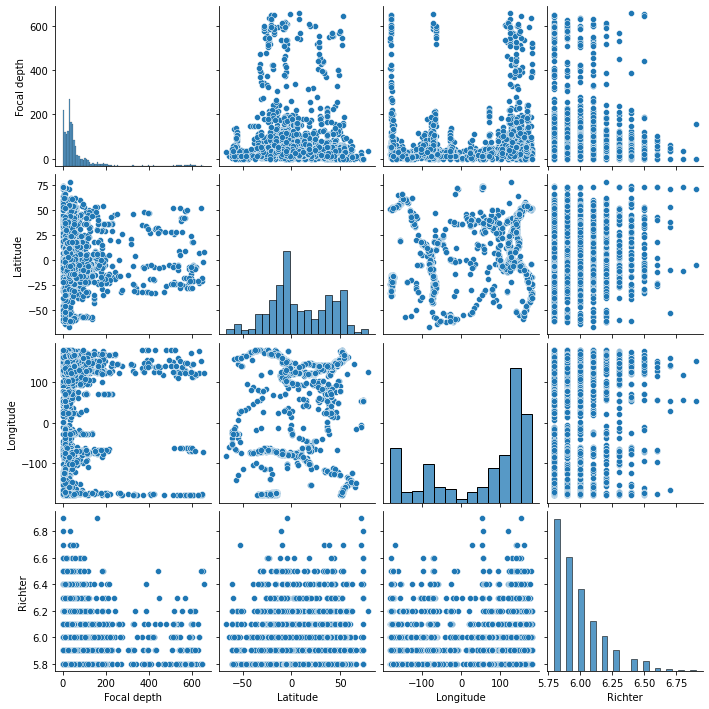

In [ ]:
sns.pairplot(data,vars=data.columns[:4])

Well,from graphs above we can see some geographic areas by richter scale and focal depth.<br>
There are some areas which are richter scale- or focal depth-gaped, that is absolutely explainable.<br>

### Clustering

In [ ]:
data['x'] = np.cos((data['Latitude']/180)*np.pi)*np.cos((data['Longitude']/180)*np.pi)
data['y'] = np.cos((data['Latitude']/180)*np.pi)*np.sin((data['Longitude']/180)*np.pi)
data['z'] = np.sin((data['Latitude']/180)*np.pi)

In [ ]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[['x','y','z','Focal depth','Richter']]),columns = ['x s','y s','z s','Focal depth s','Richter s'])
data_scaled

x s       y s       z s  Focal depth s  Richter s
0     1.912966  0.106615 -1.912599      -0.355201   3.816707
1    -0.425673  0.197995  1.251600      -0.329437  -0.935570
2    -0.386844  0.398605  1.153935      -0.149088  -0.935570
3    -0.563006  0.575292  0.776449      -0.063208   1.176553
4    -1.040077 -0.122329 -1.025650      -0.380965   0.120492
...        ...       ...       ...            ...        ...
2173 -0.436215 -0.557493  1.397620      -0.526962  -0.935570
2174 -1.072615  0.161450 -0.620348       0.194433  -0.407539
2175 -0.547602  0.623314  0.733878       3.887289  -0.935570
2176 -0.451706  0.500534  0.999676      -0.200616   0.120492
2177 -0.171433  0.984974  0.606815      -0.286497  -0.935570

[2178 rows x 5 columns]

In order to somehow visualize clustering results I'll reduce feature set to 3 features.<br>
To still have results of clustering interpretable `x`,`y` and `z` will be converted into `Coordinates` and other features will remain unchanged.

In [ ]:
data=pd.concat([data,data_scaled],axis=1)
data.head()

Focal depth  Latitude  Longitude  ...       z s  Focal depth s  Richter s
0           33    -52.26      28.30  ... -1.912599      -0.355201   3.816707
1           36     45.53     150.93  ...  1.251600      -0.329437  -0.935570
2           57     41.85     142.78  ...  1.153935      -0.149088  -0.935570
3           67     29.19     141.15  ...  0.776449      -0.063208   1.176553
4           30    -21.66     169.81  ... -1.025650      -0.380965   0.120492

[5 rows x 12 columns]

In [ ]:
pca = PCA(n_components=1)
data['Coordinates']= pca.fit_transform(data_scaled.loc[:,['x s','y s','z s']])
data

Focal depth  Latitude  Longitude  ...  Focal depth s  Richter s  Coordinates
0              33    -52.26      28.30  ...      -0.355201   3.816707     1.646504
1              36     45.53     150.93  ...      -0.329437  -0.935570    -0.802530
2              57     41.85     142.78  ...      -0.149088  -0.935570    -0.898612
3              67     29.19     141.15  ...      -0.063208   1.176553    -1.009077
4              30    -21.66     169.81  ...      -0.380965   0.120492    -0.171865
...           ...       ...        ...  ...            ...        ...          ...
2173           13     51.54    -173.11  ...      -0.526962  -0.935570    -0.290090
2174           97    -10.16     161.01  ...       0.194433  -0.407539    -0.535757
2175          527     27.87     139.51  ...       3.887289  -0.935570    -1.022287
2176           51     36.43     140.98  ...      -0.200616   0.120492    -0.961930
2177           41     24.02     122.23  ...      -0.286497  -0.935570    -1.035259

[2178 rows x 13 columns]

In [ ]:
columns_to_cluster = ['Focal depth s','Richter s','x s','y s','z s']

In [ ]:
kmeans = KMeans(n_clusters = 15,random_state = 0)
data['kmeans15'] = kmeans.fit_predict(data[columns_to_cluster])

In [ ]:
data.head()

Focal depth  Latitude  Longitude  ...  Richter s  Coordinates  kmeans15
0           33    -52.26      28.30  ...   3.816707     1.646504         0
1           36     45.53     150.93  ...  -0.935570    -0.802530         8
2           57     41.85     142.78  ...  -0.935570    -0.898612         8
3           67     29.19     141.15  ...   1.176553    -1.009077         6
4           30    -21.66     169.81  ...   0.120492    -0.171865         2

[5 rows x 14 columns]

### Optimal K

*A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.*

In [ ]:
def plot_inertias(n_clust_grid,inertias,**plotting_params):
    plt.figure(figsize=plotting_params['figsize'])
    plt.plot(n_clust_grid, inertias, marker="*")
    plt.xlabel(plotting_params['x_lab'])
    plt.ylabel(plotting_params['y_lab'])
    plt.title(plotting_params['title'])

In [ ]:
inertias = []

def calc_visualize_inertias(model,range_,X,**visual_params):
    n_clust_grid = [i for i in range_]
    print(n_clust_grid)
    for n_clusters in n_clust_grid:
        model_ = model(n_clusters=n_clusters, random_state=0)
        cluster_labels = model_.fit_predict(X)
    
        inertias.append(model_.inertia_)
        print(f'Cluster:Inertia - {n_clusters}:{model_.inertia_} ')
    
    plot_inertias(n_clust_grid,inertias,**visual_params)    

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Cluster:Inertia - 2:8430.967359699833 
Cluster:Inertia - 3:6665.836530220744 
Cluster:Inertia - 4:5148.307312901593 
Cluster:Inertia - 5:4288.331306587891 
Cluster:Inertia - 6:3726.780655309019 
Cluster:Inertia - 7:3321.281835071404 
Cluster:Inertia - 8:3060.3119471134087 
Cluster:Inertia - 9:2836.55925338818 
Cluster:Inertia - 10:2671.4873513415723 
Cluster:Inertia - 11:2534.1917432098207 
Cluster:Inertia - 12:2402.0081702732987 
Cluster:Inertia - 13:2264.841966153488 
Cluster:Inertia - 14:2178.8704551387264 
Cluster:Inertia - 15:2078.8291366567946 


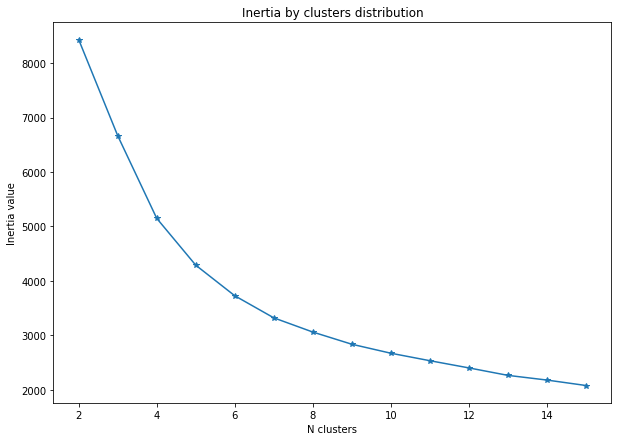

In [ ]:
calc_visualize_inertias(KMeans,range(2,16),data.loc[:,columns_to_cluster],
              figsize=(10,7),
              x_lab='N clusters',
              y_lab='Inertia value',
              title='Inertia by clusters distribution')

*To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is $6$.*

In [ ]:
inertias

[8430.967359699833,
 6665.836530220744,
 5148.307312901593,
 4288.331306587891,
 3726.780655309019,
 3321.281835071404,
 3060.3119471134087,
 2836.55925338818,
 2671.4873513415723,
 2534.1917432098207,
 2402.0081702732987,
 2264.841966153488,
 2178.8704551387264,
 2078.8291366567946]

In [ ]:
[(abs(inertias[ix]-inertias[ix+1])/abs(inertias[ix-1] - inertias[ix])) for ix in range(1,13)]

[0.8597261981804443,
 0.5666948593140929,
 0.6529840915980506,
 0.7221055114336246,
 0.6435774284252467,
 0.8573889327846241,
 0.7377426358465125,
 0.8317321508356189,
 0.9627662147042322,
 1.0376947836451758,
 0.6267689010309581,
 1.1636566264928638]

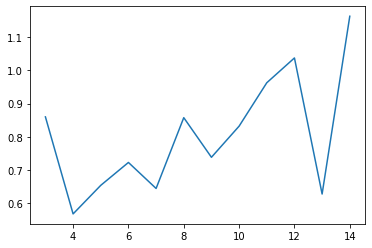

In [ ]:
plt.plot(range(3,15),[(abs(inertias[ix]-inertias[ix+1])/abs(inertias[ix-1] - inertias[ix])) for ix in range(1,13)])

*Another way to assess results of clustering without general truth data is silhoette method.*<br>
*The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.*

In [ ]:
def get_data_clusters(x,y,z,labels,data,**vis_params):
    fig = vis_params['fig']
    for name in sorted(np.unique(labels)):
        df = data[labels == name]
        trace1 = go.Scatter3d(
            x= df[x],
            y= df[y],
            z= df[z],
            mode='markers',
            name=f'cluster{name}',
            showlegend=False,
            marker=dict(
                color=vis_params['colors'][name],                # set color to an array/list of desired values
            )
        )
        fig.add_trace(trace1,row=vis_params['rows'],col=vis_params['cols'])
    fig.update_layout(scene = dict(
                                    xaxis = dict(title  = 'Coordinates'),
                                    yaxis = dict(title  = 'Focal depth'),
                                    zaxis = dict(title  = 'Richter')))
    return fig

In [ ]:
def plot_silhouette(fig,silhouette_avg,n_clusters,sample_silhouette_values,cluster_labels):
    y_lower = 10
    size_clusters = []
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        size_clusters.append(size_cluster_i)
        y_upper = y_lower + size_cluster_i
        
        filled_area = go.Scatter(y=np.arange(y_lower, y_upper),
                                 x=ith_cluster_silhouette_values,
                                 mode='lines',
                                 showlegend=False,
                                 line=dict(width=0.5,
                                          color=color_clusters[i]),
                                 fill='tozerox')
        fig.add_trace(filled_area, 1, 1)
        y_lower = y_upper + 10  
    
    print('Entropy of cluster size intervals:',entropy(size_clusters)/len(size_clusters))
    axis_line = go.Scatter(x=[silhouette_avg,silhouette_avg],
                           y=[0, y_upper],
                           showlegend=False,
                           mode='lines',
                           line=dict(color="red", dash='dash',
                                     width =1))

    fig.append_trace(axis_line, 1, 1)
    return size_clusters

In [ ]:
def visualize_silhouette_scatter(model,data,color_clusters,columns_to_cluster,basic_clusters):
       
    figures = []
    
    for ix, n_clusters in enumerate(basic_clusters):
        # Create a subplot with 1 row and 2 columns
        fig = make_subplots(rows=1, cols=2,
                                  print_grid=False,
                                  subplot_titles=('The silhouette plot for the various clusters.',
                                                  'The visualization of the clustered data.'),
                                   specs=[[{'type': 'scatter'},{'type': 'scene'}]])
        
        clusterer = model(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(data[columns_to_cluster])
    
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data[columns_to_cluster], cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
    
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data[columns_to_cluster], cluster_labels)
        
        size_clusters = plot_silhouette(fig,silhouette_avg,n_clusters,sample_silhouette_values,cluster_labels)
        clustered_data = get_data_clusters('Coordinates','Focal depth s','Richter s',cluster_labels,data,
                                           fig=fig,rows=1,cols=2,colors=color_clusters)                            
        
        fig.update_xaxes(title='Silhoette value',
                                       zeroline=False,row=1,col=1)
        fig.update_yaxes(title='Point number scale',
                                       zeroline=False,row=1,col=1)
        
        fig['layout'].update(title=f"Silhouette analysis for {clusterer.__class__.__name__} clustering on sample data "
                             "with n_clusters = %d" % n_clusters,
                                )
        figures.append(fig)
    return figures

In [ ]:
basic_clusters = [4,5,6,7,15]
color_clusters = ['teal',  'aqua', 'violet','olive','brown',
                  'black', 'blanchedalmond', 'blue','red','yellow',
                  'purple','green','gray','orange','coral','plum','goldenrod',
                  'saddlebrown','maroon','darkgreen']

In [ ]:
silhoette_figs = visualize_silhouette_scatter(KMeans,data,color_clusters,columns_to_cluster,basic_clusters)

For n_clusters = 4 The average silhouette_score is : 0.32165386495505627
Entropy of cluster size intervals: 0.29661544638170567
For n_clusters = 5 The average silhouette_score is : 0.3291872336028197
Entropy of cluster size intervals: 0.2882243769043438
For n_clusters = 6 The average silhouette_score is : 0.34169225809088144
Entropy of cluster size intervals: 0.27437340414735706
For n_clusters = 7 The average silhouette_score is : 0.3191877529037691
Entropy of cluster size intervals: 0.2682370719564731
For n_clusters = 15 The average silhouette_score is : 0.2927445497228444
Entropy of cluster size intervals: 0.16756993594507963


In [ ]:
for j in range(len(basic_clusters)):
    py_of.iplot(silhoette_figs[j])

***Good, let's analyze obtained plots.<br>***
 *- Uniformity of cluster sizes decreases with n_clusters increase(see normalized entropy)*<br>
 *- Kmeans clustering with n_clusters equal 15 and 7 there are lots of outliers(negative silhoette values) and fluctuation in clusters' thickness.<br>*
 *- Kmeans clustering with n_clusters equal 4,5 and 6 have less outliers and non-uniformly distributed thickness of clusters as well,case with n_clusters = 4 has best uniformity(due to value of normalized entropy). The average silhouette_score is biggest for n_clusters=6,and in this case cluster scores cross avg score best, thus I'll take n_clusters=6 as best clustering hyperparameter as more robust for higher-dimensional data.*

***Let's interpret results***<br>
*Our visualizations are 3-dimensional scatter plots, thus clustering will be considered as 'good' if data will be divided into clusters, taking into account each of dimensions.<br>
BUT dimension `Coordinates` is component of (x,y,z), so that if there's  dense area of observations with relatively equal mean of `Richter`,and `Focal depth` represented by several clusters - it should be considered as 'good' clustering, because there are points,close on `Coordinates` axis, but geographically far from each other,it means geographical clustering.*<br>
**For instance, let's have a look at n_clusters = 6:<br>**
 - Cluster3 has high focal depth with low to medium richter scale and high geographical variance.
 - Cluster5 has low geographical variance but is situated quite far from others observations,has from low to medium richter scale and low focal depth
 - Cluster1 has medium to high richter and low focal depth.
 - Cluster0,2,4 have relatively equal means of focal depth,and richter, and on the visualization look nearby, but actually seems they're geographically different. 

In [ ]:
kmeans = KMeans(n_clusters = 6,random_state = 0)
data['kmeans6'] = kmeans.fit_predict(data[columns_to_cluster])
data.head()

Focal depth  Latitude  Longitude  ...  Coordinates  kmeans15  kmeans6
0           33    -52.26      28.30  ...     1.646504         0        4
1           36     45.53     150.93  ...    -0.802530         8        2
2           57     41.85     142.78  ...    -0.898612         8        2
3           67     29.19     141.15  ...    -1.009077         6        4
4           30    -21.66     169.81  ...    -0.171865         2        1

[5 rows x 15 columns]

### Agglomerative clustering

In [ ]:
aglom_clusterer = AgglomerativeClustering(distance_threshold=3,n_clusters=None,linkage='average')
y_aglomerative = aglom_clusterer.fit_predict(data[columns_to_cluster])

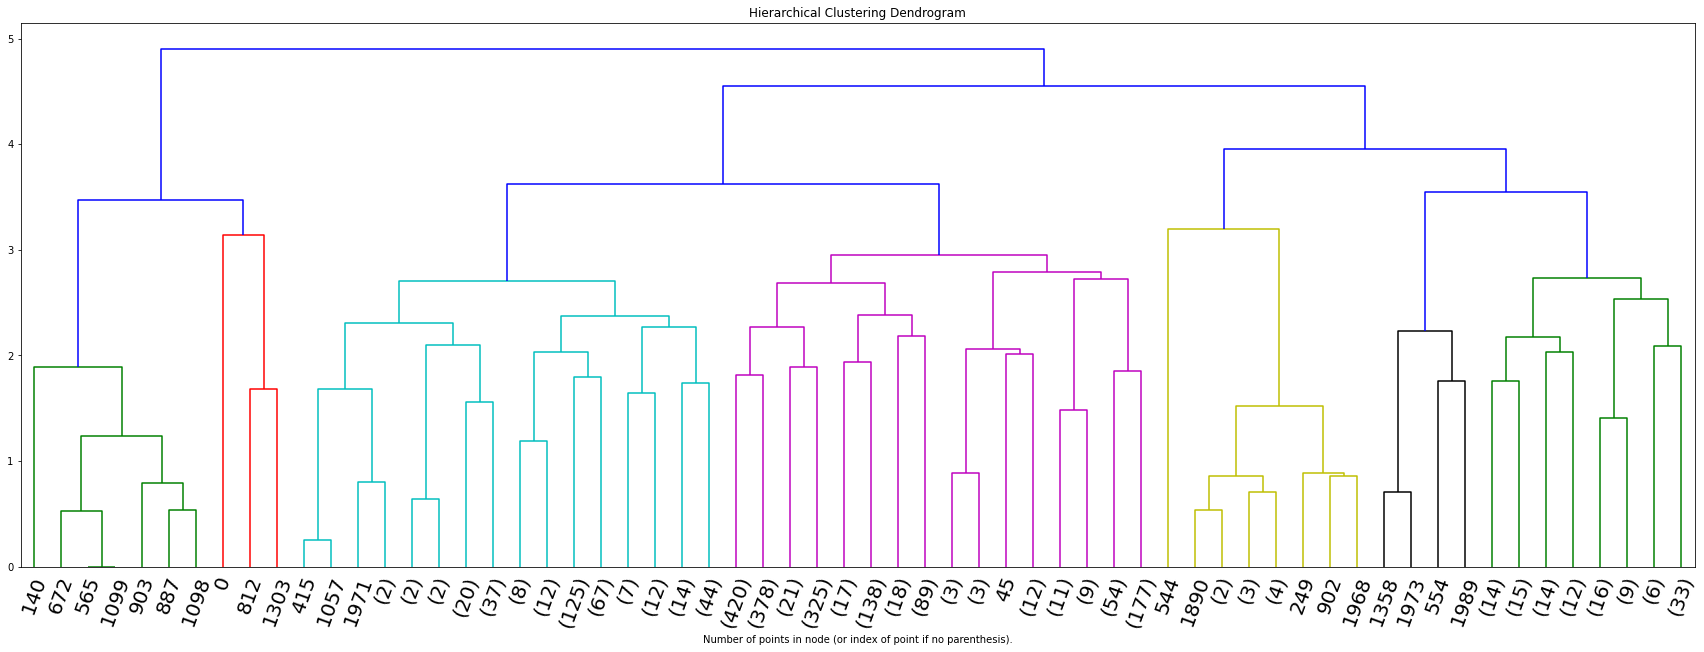

In [ ]:
plot_dendrogram(aglom_clusterer,truncate_mode='level', p=6)

In [ ]:
fig = get_data_clusters('Coordinates','Focal depth s','Richter s',y_aglomerative,data,fig=make_subplots(rows=1, cols=1,
                                 specs=[[{'type': 'scene'}]]),colors=color_clusters,rows=1,cols=1)
fig.update_layout(title=f'Agglomerative clustering,linkage-{aglom_clusterer.linkage}, n_clusters={aglom_clusterer.n_clusters_}',height=700,width=700)

In [ ]:
def make_generator(parameters):
    if not parameters:
        yield dict()
    else:
        key_to_iterate = list(parameters.keys())[0]
        next_round_parameters = {p : parameters[p]
                    for p in parameters if p != key_to_iterate}
        for val in parameters[key_to_iterate]:
            for pars in make_generator(next_round_parameters):
                temp_res = pars
                temp_res[key_to_iterate] = val
                yield temp_res

In [ ]:
adjusted_rand_score.__code__.co_varnames

('labels_true',
 'labels_pred',
 'n_samples',
 'n_classes',
 'n_clusters',
 'contingency',
 'sum_comb_c',
 'sum_comb_k',
 'sum_comb',
 'prod_comb',
 'mean_comb')

In [ ]:
scorer_typecheck=lambda scorer,labels,X: labels if scorer.__code__.co_varnames[0]=='labels_true' else X 

In [ ]:
def renew_best_models(clusterizer,best_models,scorers,X_scaled,labels_pred,labels_true):
    for scorer in scorers:
        score = scorer(scorer_typecheck(scorer,labels_true,X_scaled),labels_pred)
        if best_models.setdefault(scorer.__name__,[-1000])[0] < score:
            best_models[scorer.__name__] = [score,clusterizer]
    
    return best_models

In [ ]:
data.head()

Focal depth  Latitude  Longitude  ...  Coordinates  kmeans15  kmeans6
0           33    -52.26      28.30  ...     1.646504         0        4
1           36     45.53     150.93  ...    -0.802530         8        2
2           57     41.85     142.78  ...    -0.898612         8        2
3           67     29.19     141.15  ...    -1.009077         6        4
4           30    -21.66     169.81  ...    -0.171865         2        1

[5 rows x 15 columns]

In [ ]:
param_grid = {
    'n_clusters' : [3,5,7,8,11,15],
    'linkage': ['ward','complete', 'average', 'single'],
    'affinity': ['euclidean','l1','l2','manhattan','cosine']
}

best_models = dict()

scorers = [
    silhouette_score,
    adjusted_rand_score
]

def tune_hyperparameters(model,param_grid,data,columns_to_cluster,best_models,pred_col='kmeans6'): 
    for params in make_generator(param_grid):
        print(params)
        clusterizer = model(**params)
        try:
            clusterizer.fit(data[columns_to_cluster])
        except ValueError as err:
            print(err)
            continue
        labels = clusterizer.labels_
        best_models=renew_best_models(clusterizer,best_models,scorers,data[columns_to_cluster],labels,data[pred_col])
    return best_models

tune_hyperparameters(AgglomerativeClustering,param_grid,data,columns_to_cluster,best_models)

{'affinity': 'euclidean', 'linkage': 'ward', 'n_clusters': 3}
{'affinity': 'l1', 'linkage': 'ward', 'n_clusters': 3}
l1 was provided as affinity. Ward can only work with euclidean distances.
{'affinity': 'l2', 'linkage': 'ward', 'n_clusters': 3}
l2 was provided as affinity. Ward can only work with euclidean distances.
{'affinity': 'manhattan', 'linkage': 'ward', 'n_clusters': 3}
manhattan was provided as affinity. Ward can only work with euclidean distances.
{'affinity': 'cosine', 'linkage': 'ward', 'n_clusters': 3}
cosine was provided as affinity. Ward can only work with euclidean distances.
{'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 3}
{'affinity': 'l1', 'linkage': 'complete', 'n_clusters': 3}
{'affinity': 'l2', 'linkage': 'complete', 'n_clusters': 3}
{'affinity': 'manhattan', 'linkage': 'complete', 'n_clusters': 3}
{'affinity': 'cosine', 'linkage': 'complete', 'n_clusters': 3}
{'affinity': 'euclidean', 'linkage': 'average', 'n_clusters': 3}
{'affinity': 'l1', 'li

{'adjusted_rand_score': [0.6830910200153306,
  AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                          connectivity=None, distance_threshold=None,
                          linkage='ward', memory=None, n_clusters=5)],
 'silhouette_score': [0.4686041359552029,
  AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                          connectivity=None, distance_threshold=None,
                          linkage='single', memory=None, n_clusters=3)]}

In [ ]:
best_models['silhouette_score'][1].labels_

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
def clustering_report(groundtruth,X,best_models,**vis_params):    
    
    silhouete_bm,rand_bm = best_models['silhouette_score'],best_models['adjusted_rand_score']
    print(f'Best model by silhouette score = {silhouete_bm[0]},\n'\
            f'rand score = {adjusted_rand_score(groundtruth,silhouete_bm[1].labels_)} - {silhouete_bm[1]}\n')
    print(f'Best model by rand score = {rand_bm[0]},\n'\
            f'silhouette score = {silhouette_score(X,rand_bm[1].labels_)} - {rand_bm[1]}\n')
    
    fig = make_subplots(rows=2, cols=2,print_grid=False,
                                        subplot_titles=(f"The silhouette plot for tuned {vis_params['type_']}",
                                                        f"Clustering visualization for {vis_params['type_']}",
                                                        f"Tuned {vis_params['type_']} closest to ground truth",
                                                        'Ground truth clustering - kmeans6'),
                                
                                        specs=[[{'type': 'scatter'},{'type': 'scene'}],[{'type': 'scene'},{'type': 'scene'}]])
    
    sample_silhouette_values = silhouette_samples(data[columns_to_cluster], silhouete_bm[1].labels_)
            
    size_clusters = plot_silhouette(fig,silhouete_bm[0],len(np.unique(silhouete_bm[1].labels_)),
                                    sample_silhouette_values,silhouete_bm[1].labels_)
    clustered_data = get_data_clusters('Coordinates','Focal depth s','Richter s',silhouete_bm[1].labels_,data,
                                                fig=fig,rows=1,cols=2,colors=color_clusters)
    
    get_data_clusters('Coordinates','Focal depth s','Richter s',rand_bm[1].labels_,data,
                                                fig=fig,rows=2,cols=1,colors=color_clusters)
    get_data_clusters('Coordinates','Focal depth s','Richter s',data['kmeans6'],data,
                                                fig=fig,rows=2,cols=2,colors=color_clusters)
    
    
    fig.update_layout(title=f"{vis_params['type_']}",height=1200,width=1400)
    
    
    py_of.iplot(fig)

In [ ]:
clustering_report(data['kmeans6'],data[columns_to_cluster],best_models)

Best model by silhouette score = 0.4686041359552029,
rand score = 0.005593036472736026 - AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='single', memory=None, n_clusters=3)

Best model by rand score = 0.6830910200153306,
silhouette score = 0.31443616783995065 - AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

Entropy of cluster size intervals: 0.013501199643911764


***Interpretation of clusters***
Nice,
- I can see in `AgglomerativeClustering(linkage='single', n_clusters=3)` model 3 tightly-coupled clusters with relative high average ***silhouette score***,although clusters' are imbalanced and you can see it as well.*Such imbalancy can be explained with usage linkage='single',it means that cluster distance is calculated as minimum of the distances between all observations of the two sets - this clarifies cluster density*. **Here cluster1 differs from cluster2 in richter scale,but clusters 1 and 2 aren't different from cluster0 in dimensions' range**. <br>
- Let's consider `AgglomerativeClustering(n_clusters=5)` model, that showed best ***adjusted rand score***.As ground truth I used cluster labels from kmeans6,so that clusters are similarly distributed on the scatters.Relative point pairs are situated or not in both subsets by nearly 68%.This model labels are most similar to ground truth model `KMeans(n_clusters=6)`among Agglomerative clustering.***Interpretation of clusters in this case is similar to kmeans6 except that richter values are better separated in case kmeans6***
- `KMeans(n_clusters=6)` as groundtruth is preferable to `AgglomerativeClustering(n_clusters=5)` not only because of higher silhouette, but also because it separates Richter scale better and you can see it as well

### DBSCAN

In [ ]:
min_samples = len(columns_to_cluster)*2 #rule of thumb
dbscan = DBSCAN(eps=0.5,min_samples=min_samples)
dbscan_clusters = dbscan.fit_predict(data[columns_to_cluster])

In [ ]:
fig = get_data_clusters('Coordinates','Focal depth s','Richter s',dbscan_clusters,data,fig=make_subplots(rows=1, cols=1,
                                 specs=[[{'type': 'scene'}]]),colors=color_clusters,rows=1,cols=1)
fig.update_layout(title=f'DBSCAN clustering: eps={dbscan.eps}, min_samples={min_samples},clusters={len(np.unique(dbscan_clusters))}',height=700,width=700)

In [ ]:
param_grid_dbscan = {
    'min_samples': [x for x in range(2, 30, 1)],
    'eps': np.linspace(0.5,1,10)
}

best_models = dict()

In [ ]:
tune_hyperparameters(DBSCAN,param_grid_dbscan,data,columns_to_cluster,best_models)

{'eps': 0.5, 'min_samples': 2}
{'eps': 0.5555555555555556, 'min_samples': 2}
{'eps': 0.6111111111111112, 'min_samples': 2}
{'eps': 0.6666666666666666, 'min_samples': 2}
{'eps': 0.7222222222222222, 'min_samples': 2}
{'eps': 0.7777777777777778, 'min_samples': 2}
{'eps': 0.8333333333333333, 'min_samples': 2}
{'eps': 0.8888888888888888, 'min_samples': 2}
{'eps': 0.9444444444444444, 'min_samples': 2}
{'eps': 1.0, 'min_samples': 2}
{'eps': 0.5, 'min_samples': 3}
{'eps': 0.5555555555555556, 'min_samples': 3}
{'eps': 0.6111111111111112, 'min_samples': 3}
{'eps': 0.6666666666666666, 'min_samples': 3}
{'eps': 0.7222222222222222, 'min_samples': 3}
{'eps': 0.7777777777777778, 'min_samples': 3}
{'eps': 0.8333333333333333, 'min_samples': 3}
{'eps': 0.8888888888888888, 'min_samples': 3}
{'eps': 0.9444444444444444, 'min_samples': 3}
{'eps': 1.0, 'min_samples': 3}
{'eps': 0.5, 'min_samples': 4}
{'eps': 0.5555555555555556, 'min_samples': 4}
{'eps': 0.6111111111111112, 'min_samples': 4}
{'eps': 0.6666666

{'adjusted_rand_score': [0.3482251029907768,
  DBSCAN(algorithm='auto', eps=0.6666666666666666, leaf_size=30,
         metric='euclidean', metric_params=None, min_samples=25, n_jobs=None,
         p=None)],
 'silhouette_score': [0.3544941016572916,
  DBSCAN(algorithm='auto', eps=1.0, leaf_size=30, metric='euclidean',
         metric_params=None, min_samples=21, n_jobs=None, p=None)]}

In [ ]:
clustering_report(data['kmeans6'],data[columns_to_cluster],best_models,type_='DBSCAN clustering')

Best model by silhouette score = 0.3544941016572916,
rand score = 0.07403597366289881 - DBSCAN(algorithm='auto', eps=1.0, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=21, n_jobs=None, p=None)

Best model by rand score = 0.3482251029907768,
silhouette score = 0.17114175874013213 - DBSCAN(algorithm='auto', eps=0.6666666666666666, leaf_size=30,
       metric='euclidean', metric_params=None, min_samples=25, n_jobs=None,
       p=None)

Entropy of cluster size intervals: 0.0


In [ ]:
data.head()

Focal depth  Latitude  Longitude  ...  Richter s  Coordinates  kmeans15
0           33    -52.26      28.30  ...   3.816707     1.646504         0
1           36     45.53     150.93  ...  -0.935570    -0.802530         8
2           57     41.85     142.78  ...  -0.935570    -0.898612         8
3           67     29.19     141.15  ...   1.176553    -1.009077         6
4           30    -21.66     169.81  ...   0.120492    -0.171865         2

[5 rows x 14 columns]

In [ ]:
data['kmeans6'].unique()

array([4, 2, 1, 5, 3, 0], dtype=int32)

In [ ]:
colors = ["red", "blue", "green", "purple", "orange", "darkred",
          "lightred", "beige", "darkblue", "darkgreen", "cadetblue", "darkpurple", 
          "white", "pink", "lightblue", "lightgreen", "gray", "black", "lightgray"]

m = folium.Map(location=[0, 0], zoom_start=1, disable_3d=True, prefer_canvas=True)
"""clusterMarkers = []
for i in range(K):
    clusterMarkers.append(MarkerCluster().add_to(m))"""
for i, row in data.iterrows():
    if row['Longitude'] > 180:
        coords = [row['Latitude'], row['Longitude']-360]
    else:
        coords = [row['Latitude'], row['Longitude']]
    cluster_id = int(row['kmeans6'])
    folium.Marker(location=coords,popup=f"Cluster {cluster_id}\nFocal depth={row['Focal depth']}\nRichter {row.Richter}", icon=folium.Icon(color=colors[cluster_id])).add_to(m)
m

Great, looks like there are more strong quakes in northern hemisphere and they're deeper than in southern